<font size="+3">Принятие решений в бизнесе для интернет-магазина с использованием A/B теста</font>

# Описание данных

**Источники данных:**

Структура `orders.csv`:
- `transactionId` — идентификатор заказа,
- `visitorId` — идентификатор пользователя, совершившего заказ,
- `date` — дата, когда был совершён заказ,
- `revenue` —  выручка заказа,
- `group`— группа A/B-теста, в которую попал заказ.

Структура `visitors.csv`:
- `date` — дата,
- `group` — группа A/B-теста,
- `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста.

# Описание задания

## Анализ A/B-теста

Вы провели A/B-тест и получили результаты, которые описаны в файлах `orders.csv` и `visitors.csv`.

**Задача**

Проанализировать A/B-тест:

1. Построить графики и визуализировать относительные изменения основных показателей по группам.
2. Посчитать статистическую значимость различий между группами по «сырым» и «очищенным» данным. Сделать выводы и предположения.
3. Принять решение по результатам теста и объяснить его. Варианты решений: 1. Остановить тест, зафиксировать победу одной из групп. 2. Остановить тест, зафиксировать отсутствие различий между группами. 3. Продолжить тест.

# Загрузка и предобработка данных 

## Загрузка таблиц и библиотек

Загрузим необходимые библиотеки для работы с данными, и присвоим таблицы переменным функцией `read_csv`

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import seaborn as sns
import scipy.stats as stats

In [2]:
orders = pd.read_csv('C:/Users/Georgii/Desktop/ANALYTICS/AB_DATA/orders.csv')
visitors = pd.read_csv('C:/Users/Georgii/Desktop/ANALYTICS/AB_DATA/visitors.csv')

In [3]:
all_data = [orders, visitors] # Датафреймы, по которым проходится цикл
pd.options.display.max_colwidth = 110
for element in all_data:
    display (element.head())

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [4]:
for element in all_data:
    display (element.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


None

***Вывод: Данные выглядят корректно. Необходимо выполнить их предобработку, привести определенные данные к нужному типу.***

## Предобработка данных

Проверим наличие пропусков в датафреймах, продолжая использовать список таблиц `all_data` для перебора таблиц в цикле.

In [5]:
for element in all_data:
    print (element.isna().sum())

transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64
date        0
group       0
visitors    0
dtype: int64


Теперь проверим наличие дубликатов.

In [6]:
for element in all_data:
    print (element.duplicated().sum())

0
0


Приведем названия столбцов к змеиному регистру.

In [7]:
orders.columns = ['transaction_id', 'visitor_id', 'date', 'revenue', 'group']

Поменяем типы данных в столбцах `date`, чтобы иметь возможность проводить расчеты с датами.

In [8]:
orders['date'] = pd.to_datetime(orders['date'])
visitors['date'] = pd.to_datetime(visitors['date'])

***Вывод: Предобработка проведена. Изменены названия столбцов. Изменены типы данных в столбцах с датами.***

# Анализ A/B-теста

## Анализ кумулятивной выручки и среднего чека по группам

В данном A/B тесте мы рассматриваем 2 группы наблюдаемых пользователей. Определим временные рамки теста и количество пользователей в каждой группе.

In [9]:
display (orders.date.max())
display (orders.date.min())

Timestamp('2019-08-31 00:00:00')

Timestamp('2019-08-01 00:00:00')

In [10]:
display (orders.query('group == "A"').visitor_id.nunique())
display (orders.query('group == "B"').visitor_id.nunique())

503

586

*Тест проводился с 2019-08-01 по 2019-08-31. Количество уникальных пользователей в сегменте A - 503 пользователей, в сегменте B - 586 пользователей. Группы кажутся относительно сбалансированными.*

Построим графики кумулятивной выручки по тестовым группам A и B. Для этого разобьем заказы по группам.

In [11]:
orders_a = orders.query('group == "A"')
orders_b = orders.query('group == "B"')

Агрегируем выручку по дате и считаем накопленную выручку

In [12]:
orders_a_revenue = orders_a.groupby('date', as_index=False)['revenue'].sum()
orders_b_revenue = orders_b.groupby('date', as_index=False)['revenue'].sum()

In [13]:
orders_a_revenue = orders_a_revenue.apply(
    lambda x: orders_a_revenue[orders_a_revenue['date'] <= x['date']]
    .agg({'date':'max', 'revenue':'sum'}),
    axis=1
)

orders_b_revenue = orders_b_revenue.apply(
    lambda x: orders_b_revenue[orders_b_revenue['date'] <= x['date']]
    .agg({'date':'max', 'revenue':'sum'}),
    axis=1
)

Строим графики 

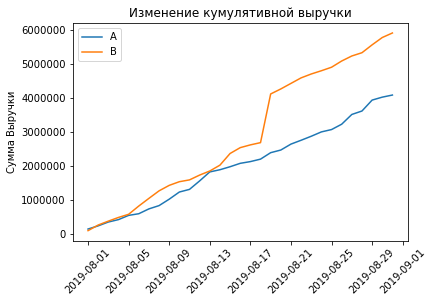

In [14]:
plt.ticklabel_format(style='plain')
plt.plot(orders_a_revenue['date'], orders_a_revenue['revenue'], label='A')
plt.plot(orders_b_revenue['date'], orders_b_revenue['revenue'], label='B')
plt.xticks(rotation=45)
plt.ylabel('Сумма Выручки')
plt.title('Изменение кумулятивной выручки')
plt.legend();

*В районе 17 числа наблюдается резкий скачок у группы B, что делает суммарно сегмент B выгоднее чем сегмент A на данный момент исследования. Возможно играет свою роль какое-то выбивающееся значение.*

Подготовим данные и построим графики кумулятивных значений среднего чека по тестовым группам A и B

In [15]:
orders_a_cheque =  orders_a.groupby('date', as_index=False).agg({'transaction_id':'nunique'})
orders_a_cheque = orders_a_cheque.apply(
    lambda x: orders_a_cheque[orders_a_cheque['date'] <= x['date']]
    .agg({'date':'max', 'transaction_id':'sum'}),
    axis=1
)

orders_b_cheque =  orders_b.groupby('date', as_index=False).agg({'transaction_id':'nunique'})
orders_b_cheque = orders_b_cheque.apply(
    lambda x: orders_b_cheque[orders_b_cheque['date'] <= x['date']]
    .agg({'date':'max', 'transaction_id':'sum'}),
    axis=1
)

orders_a_cheque_avg = orders_a_revenue['revenue'] / orders_a_cheque['transaction_id']
orders_b_cheque_avg = orders_b_revenue['revenue'] / orders_b_cheque['transaction_id']

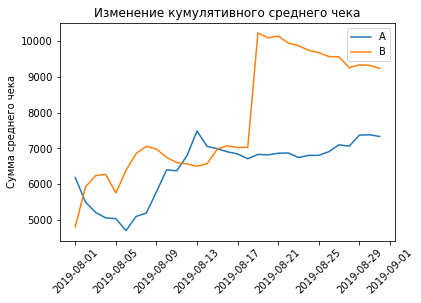

In [16]:
plt.plot(orders_a_cheque['date'], orders_a_cheque_avg, label = 'A')
plt.plot(orders_b_cheque['date'], orders_b_cheque_avg, label = 'B')
plt.xticks(rotation=45)
plt.ylabel('Сумма среднего чека')
plt.title('Изменение кумулятивного среднего чека')
plt.legend();

*На данной визуализации видно, как до середины месяца показатели двух групп суммарно растут, с разной динамикой относительно друг друга, но в схожей степени в целом. Начиная с середины месяца, также как в случае с кумулятивной конверсией, наблюдается резкий рост сегмента B, а влияние одного дня становится еще очевиднее.*

Построим графики относительного изменения кумулятивной выручки и кумулятивного среднего чека группы B к группе A.

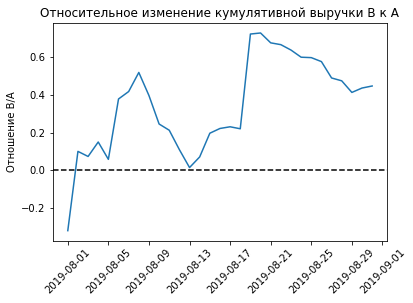

In [17]:
plt.plot(orders_b_revenue['date'], (orders_b_revenue['revenue'] / orders_a_revenue['revenue']) - 1)
plt.xticks(rotation=45)
plt.ylabel('Отношение B/A')
plt.title('Относительное изменение кумулятивной выручки B к A')
plt.axhline(y=0, color='black', linestyle='--');

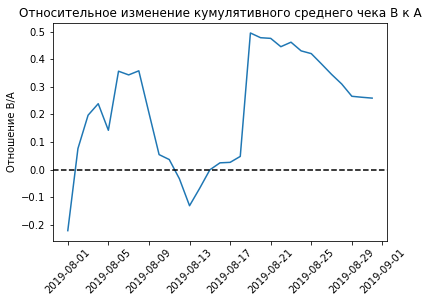

In [18]:
plt.plot(orders_a_cheque['date'], orders_b_cheque_avg / orders_a_cheque_avg - 1)
plt.xticks(rotation=45)
plt.ylabel('Отношение B/A')
plt.title('Относительное изменение кумулятивного среднего чека B к A')
plt.axhline(y=0, color='black', linestyle='--');

*Как можно заметить по приведенным выше графикам относительного изменения кумулятивной выручки и кумулятивного среднего чека, пики и впадины изменения обоих показателей совпадают по течению времени. Сначала показатели сегмента B растут, в середине месяца наблюдается провал, и после этого резкий рост одного дня. В конечном итоге, по показателям теста в первом приближении, сегмент B превосходит сегмент A и по выручке, и по среднему чеку.*

Для полноты исследования необходимо также посчитать и визуализировать тренд изменений в накопленном кол-ве заказов по дням.
Построим график кумулятивной конверсии по сегментам, а также график относительного изменения конверсии между группами.

In [19]:
# считаем срез количества заказов по дням по сегментам
avg_orders_a = orders_a.groupby('date', as_index=False).agg({'transaction_id':'count'})
avg_orders_b = orders_b.groupby('date', as_index=False).agg({'transaction_id':'count'})

# считаем кумулятивные значения количества заказов
avg_orders_a_cumul = avg_orders_a.apply(
    lambda x: avg_orders_a[avg_orders_a['date'] <= x['date']]
    .agg({'date':'max', 'transaction_id':'sum'}),
    axis=1
)
avg_orders_b_cumul = avg_orders_b.apply(
    lambda x: avg_orders_b[avg_orders_b['date'] <= x['date']]
    .agg({'date':'max', 'transaction_id':'sum'}),
    axis=1
)

# делаем срез посетителей по дням по сегментам 
visitors_a = visitors.query('group == "A"').sort_values(by='date')
visitors_b = visitors.query('group == "B"').sort_values(by='date')

# считаем кумулятивные значения посетителей
visitors_a_cumul = visitors_a.apply(
    lambda x: visitors_a[visitors_a['date'] <= x['date']]
    .agg({'date':'max', 'visitors':'sum'}),
    axis=1
)


visitors_b_cumul = visitors_b.apply(
    lambda x: visitors_b[visitors_b['date'] <= x['date']]
    .agg({'date':'max', 'visitors':'sum'}),
    axis=1
)

In [20]:
# считаем кумулятивную конверсию 
conversion_overall = avg_orders_a_cumul.merge(avg_orders_b_cumul, on='date')
conversion_overall = conversion_overall.merge(visitors_a_cumul, on='date')
conversion_overall = conversion_overall.merge(visitors_b_cumul, on='date')
conversion_a_cumul = conversion_overall['transaction_id_x'] / conversion_overall['visitors_x']
conversion_b_cumul = conversion_overall['transaction_id_y'] / conversion_overall['visitors_y']

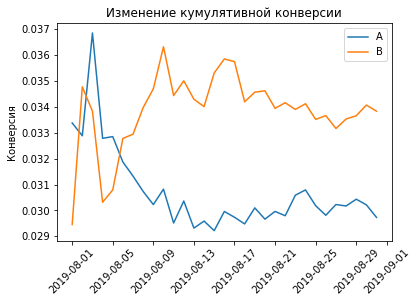

In [21]:
plt.plot(conversion_overall['date'], conversion_a_cumul, label = 'A')
plt.plot(conversion_overall['date'], conversion_b_cumul, label = 'B')
plt.xticks(rotation=45)
plt.ylabel('Конверсия')
plt.title('Изменение кумулятивной конверсии')
plt.legend();

*В первые 5 дней можно отметить относительно равные показатеои конверсии двух группы, хоть и с весьма хаотичными пиками. После, показатели сегмента B стали превосходить значения конверсии группы A до конца проведения теста.*

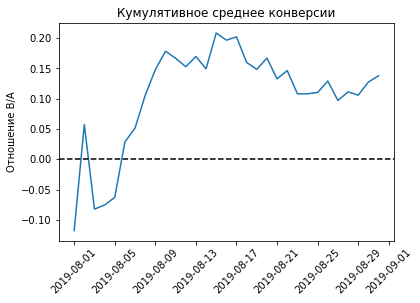

In [22]:
plt.plot(conversion_overall['date'], (conversion_b_cumul / conversion_a_cumul) - 1)
plt.xticks(rotation=45)
plt.ylabel('Отношение B/A')
plt.title('Кумулятивное среднее конверсии')
plt.axhline(y=0, color='black', linestyle='--');

*В первые дни отношение значений было трудно установить, из-за нестабильности здинамики. Начиная с 5 августа, количество заказов в сегменте B стало значительно превышать показатели сегмента A, за счет чего, к концу теста, накопленное количество заказов у сегмента B больше чем у сегмента A. Такие резкие изменения в динамике могут указывать на наличие выбросов и выбивающихся значений, и это необходимо проверить.*

## Анализ выбросов

Изучим подробнее представленные данные. Попрубуем найти выбросы, которые могут искажать результаты анализа.

Построим точечный график количества заказов по пользователям, а также посчитаем 90-й, 95-й и 99-й перцентили количества заказов на пользователя.

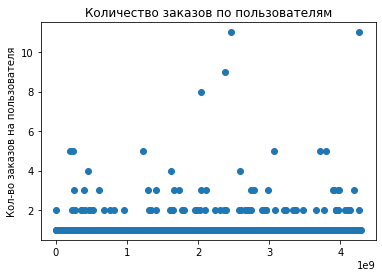

In [23]:
orders_amount = orders.groupby('visitor_id', as_index=False).agg({'transaction_id':'count'})

plt.scatter(orders_amount['visitor_id'], orders_amount['transaction_id'])
plt.ylabel('Кол-во заказов на пользователя')
plt.title('Количество заказов по пользователям');

In [24]:
transaction_perc = np.percentile(orders_amount['transaction_id'], [90, 95, 99])
transaction_perc

array([1., 2., 4.])

Аналогичную операцию проведем для стоимости заказов. В части обработки данных, мы уже нашли одно выбивающееся значение в стоимости заказа. Построим график еще раз, и найдем перцентили.

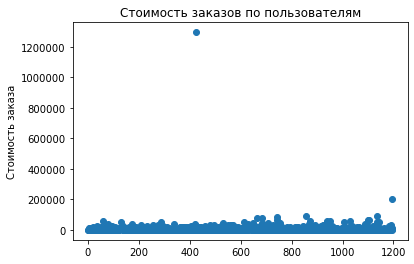

In [25]:
plt.ticklabel_format(style='plain')
plt.scatter(range(0,len(orders['transaction_id'])), orders['revenue'])
plt.ylabel('Стоимость заказа')
plt.title('Стоимость заказов по пользователям');

In [26]:
revenue_perc = np.percentile(orders['revenue'], [90, 95, 99])
revenue_perc

array([18168. , 28000. , 58233.2])

***В данных присутсвтуют выбивающиеся значения. Можно предположить, что у пользователя, который совершает больше 3-4 заказов в месяц, поводедение отличается от среднестатистического. А слишком крупные по стоимости заказы - редкое явление, которое может сильно влиять на средние значения, и тем самым, мешать правильно интерпретировать результат. Необходимо опеределится со срезом данных, отфильтровать текущие датафреймы, и провести анализ на основе новый значений.***

## Анализ среднего чека и среднего количества заказов очищенных данных

Создадим датафреймы с очищенными данными, убрав выбивающиеся значения. Для среднего количества заказов, сделаем срез до 4 заказов на пользователя, отсекая таким образом 1% данных. Для стоимости заказов установим границу в 28000, что соответствует 95-ому перцентилю, который отсекает 5% заказов.

In [27]:
# переменная с отфильтрованными данными по количеству заказов на пользователя 
visitor_id_to_filt = orders_amount.query('transaction_id > @transaction_perc[2]').visitor_id

# теперь по стоимости для двух групп
orders_a_filtered = orders_a.query('revenue < @revenue_perc[1] and visitor_id not in @visitor_id_to_filt')
orders_b_filtered = orders_b.query('revenue < @revenue_perc[1] and visitor_id not in @visitor_id_to_filt')

Посчитаем потери пользователей

In [28]:
print (f' Потери пользователей в группе A в абсолютном значении \
= {orders_a.visitor_id.nunique() - orders_a_filtered.visitor_id.nunique()} пользователя,\n Относительно сырых данных\
= {round((1 - orders_a_filtered.visitor_id.nunique() / orders_a.visitor_id.nunique())*100, 2)} %')

 Потери пользователей в группе A в абсолютном значении = 34 пользователя,
 Относительно сырых данных= 6.76 %


In [29]:
print (f' Потери пользователей в группе B в абсолютном значении \
= {orders_b.visitor_id.nunique() - orders_b_filtered.visitor_id.nunique()} пользователя,\n Относительно сырых данных\
= {round((1 - orders_b_filtered.visitor_id.nunique() / orders_b.visitor_id.nunique())*100, 2)} %')

 Потери пользователей в группе B в абсолютном значении = 39 пользователя,
 Относительно сырых данных= 6.66 %


Создаем датафреймы с очищенными данными.

In [30]:
# Расчет очищенной выручки
orders_a_revenue = orders_a_filtered.groupby('date', as_index=False)['revenue'].sum()
orders_b_revenue = orders_b_filtered.groupby('date', as_index=False)['revenue'].sum()

orders_a_revenue = orders_a_revenue.apply(
    lambda x: orders_a_revenue[orders_a_revenue['date'] <= x['date']]
    .agg({'date':'max', 'revenue':'sum'}),
    axis=1
)

orders_b_revenue = orders_b_revenue.apply(
    lambda x: orders_b_revenue[orders_b_revenue['date'] <= x['date']]
    .agg({'date':'max', 'revenue':'sum'}),
    axis=1
)

In [31]:
# аналогичный код для расчета среднего чека

orders_a_cheque =  orders_a_filtered.groupby('date', as_index=False).agg({'transaction_id':'nunique'})
orders_a_cheque = orders_a_cheque.apply(
    lambda x: orders_a_cheque[orders_a_cheque['date'] <= x['date']]
    .agg({'date':'max', 'transaction_id':'sum'}),
    axis=1
)

orders_b_cheque =  orders_b_filtered.groupby('date', as_index=False).agg({'transaction_id':'nunique'})
orders_b_cheque = orders_b_cheque.apply(
    lambda x: orders_b_cheque[orders_b_cheque['date'] <= x['date']]
    .agg({'date':'max', 'transaction_id':'sum'}),
    axis=1
)

orders_a_cheque_avg = orders_a_revenue['revenue'] / orders_a_cheque['transaction_id']
orders_b_cheque_avg = orders_b_revenue['revenue'] / orders_b_cheque['transaction_id']


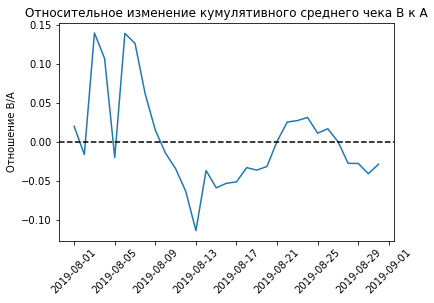

In [32]:
plt.plot(orders_a_cheque['date'], orders_b_cheque_avg / orders_a_cheque_avg - 1)
plt.xticks(rotation=45)
plt.ylabel('Отношение B/A')
plt.title('Относительное изменение кумулятивного среднего чека B к A')
plt.axhline(y=0, color='black', linestyle='--');

*Мы можем наблюдать другую картину происходящего на основе чистых данных. Теперь у сегмента B отсутствует резкий рост среднего чека в середине месяца. Скорее всего, роль в этом сыграло одно отфильтрованное значение стоимости заказа, которое можно было заметить на точечном графике количества заказов по пользователям. Теперь значение накопленного среднего у сегмента A преобладает над сегментом B.*

Посчитаем и визуализируем тренд изменений в накопленном кол-ве заказов по дням на основе отфильтрованных данных.

In [33]:
# аналогичный код для расчета среднего количества заказов

avg_orders_a = orders_a_filtered.groupby('date', as_index=False).agg({'transaction_id':'count'})
avg_orders_b = orders_b_filtered.groupby('date', as_index=False).agg({'transaction_id':'count'})

avg_orders_a['avg_orders'] = avg_orders_a['transaction_id'] / \
(visitors.query('group == "A"').sort_values(by='date').visitors)

avg_orders_b['avg_orders'] = avg_orders_b['transaction_id'] / \
(visitors.query('group == "B"').sort_values(by='date').reset_index().visitors)

avg_orders_a_cumul = avg_orders_a.apply(
    lambda x: avg_orders_a[avg_orders_a['date'] <= x['date']]
    .agg({'date':'max', 'avg_orders':'sum'}),
    axis=1
)

avg_orders_b_cumul = avg_orders_b.apply(
    lambda x: avg_orders_b[avg_orders_b['date'] <= x['date']]
    .agg({'date':'max', 'avg_orders':'sum'}),
    axis=1
)

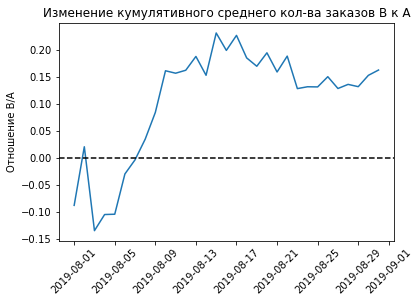

In [34]:
plt.plot(avg_orders_a_cumul['date'], (avg_orders_b_cumul['avg_orders'] / avg_orders_a_cumul['avg_orders']) - 1)
plt.xticks(rotation=45)
plt.ylabel('Отношение B/A')
plt.title('Изменение кумулятивного среднего кол-ва заказов B к A')
plt.axhline(y=0, color='black', linestyle='--');

***А вот различия в графиках среднего количества заказов почти не ощущается за исключением менее выраженного пика в начале временного отрезка. Кажется выбивающиеся значения среднего количества заказов на пользовеля не так сильно влияют на итоговый результат, или по крайней мере не влияют в том объеме, в каком они были представлены в проведенном тесте.***

***Нужно посчитать статистическую значимость различий в расчитанных значениях между сегментами, чтобы можно было формировать окончательные выводы.***

## Расчет статистической значимости показателей A/B теста

### Расчет статистической значимости для среднего количества заказов

Посчитаем статистическую значимость "сырых" и отфильтрованных данных, которые отображают различия в среднем количестве заказов между группами. 

Чтобы рассчитать статистическую значимость различий, применим критерий Манна — Уитни, используя библиотеку `scipy` и передадим методу 2 выборки: `sample_a` и `sample_b`. Заодно найдем суммарное относительное различие параметров.

Сформулируем нулевую `H_0` и альтернативную `H_a` гипотезы:

`H_0`: Различий в среднем количестве заказов между группами A и B нет

`H_a`: Различия в среднем количестве заказов между группами A и B есть

alpha = 0.05

In [35]:
orders_by_users_a = (
    orders_a
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
orders_by_users_a.columns = ['visitor_id', 'orders']

orders_by_users_b = (
    orders_b
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
orders_by_users_b.columns = ['visitor_id', 'orders']

sample_a = pd.concat(
    [
        orders_by_users_a['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitors[visitors['group'] == 'A']['visitors'].sum() - len(orders_by_users_a['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sample_b = pd.concat(
    [
        orders_by_users_b['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitors[visitors['group'] == 'B']['visitors'].sum() - len(orders_by_users_b['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print('P-value =',"{0:.5f}".format(stats.mannwhitneyu(sample_a, sample_b)[1]))

print("{0:.3f}".format(sample_b.mean() / sample_a.mean() - 1), '- Относительная разница в среднем количестве заказов на пользователя')

P-value = 0.01679
0.138 - Относительная разница в среднем количестве заказов на пользователя


Теперь для очищенных данных 

In [36]:
orders_by_users_a = (
    orders_a_filtered
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
orders_by_users_a.columns = ['visitor_id', 'orders']

orders_by_users_b = (
    orders_b_filtered
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
orders_by_users_b.columns = ['visitor_id', 'orders']

sample_a = pd.concat(
    [
        orders_by_users_a['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitors[visitors['group'] == 'A']['visitors'].sum() - len(orders_by_users_a['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sample_b = pd.concat(
    [
        orders_by_users_b['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitors[visitors['group'] == 'B']['visitors'].sum() - len(orders_by_users_b['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print('P-value =',"{0:.5f}".format(stats.mannwhitneyu(sample_a, sample_b)[1]))

print("{0:.3f}".format(sample_b.mean() / sample_a.mean() - 1), '- Относительная разница в среднем количестве заказов на пользователя')

P-value = 0.02004
0.148 - Относительная разница в среднем количестве заказов на пользователя


***По итогам расчета можно сказать, что фильтрация данных особо не повлияла на конечный результат. `P-value` сырых данных = 0.01679. 
`P-value` отфильтрованных данных = 0.02044. Если мы сравниваем это значение с показателем alpha, равным 0,05, то нулевая гипотеза отвергается. Мы можем сделать вывод, что по результатам A/B теста наблюдаются различия в итоговой конверсии заказов.***

### Расчет статистической значимости для среднего чека

Проведем аналогичную операцию для различий среднего чека. 

Сформулируем нулевую `H_0` и альтернативную `H_a` гипотезы:

`H_0`: Различий в среднем чеке между группами A и B нет

`H_a`: Различия в среднем чеке между группами A и B есть

alpha = 0.05

In [37]:
orders_a_revenue = orders_a.groupby('date', as_index=False)['revenue'].sum()
orders_b_revenue = orders_b.groupby('date', as_index=False)['revenue'].sum()
print('P-value =',"{0:.5f}".format(stats.mannwhitneyu(orders_a_revenue['revenue'], orders_b_revenue['revenue'])[1]))

print("{0:.3f}".format(orders_b_revenue['revenue'].mean() / orders_a_revenue['revenue'].mean() - 1), '- Относительная разница в среднем чеке')

P-value = 0.08587
0.446 - Относительная разница в среднем чеке


Для чистых данных

In [38]:
orders_a_revenue_filt = orders_a_filtered.groupby('date', as_index=False)['revenue'].sum()
orders_b_revenue_filt = orders_b_filtered.groupby('date', as_index=False)['revenue'].sum()
print('P-value =',"{0:.5f}".format(stats.mannwhitneyu(orders_a_revenue_filt['revenue'], orders_b_revenue_filt['revenue'])[1]))

print("{0:.3f}".format(orders_b_revenue_filt['revenue'].mean() / orders_a_revenue_filt['revenue'].mean() - 1), '- Относительная разница в среднем чеке')

P-value = 0.24260
0.126 - Относительная разница в среднем чеке


***В отличие от предыдущего расчета статистической значимости, здесь показатели P-value превышают число alpha, особенно после очистки данных. `P-value` сырых данных = 0.08587. 
`P-value` отфильтрованных данных = 0.21538. Нет причин отвергать нулевую гипотеза. Различий в среднем чеке для сегментов A и B нет.***

# Выводы

**По итогам результатам работы были проделаны следующие шаги по проекту:**
- ***Проведена приоритизация существующих гипотез***
- ***Обработан файл с даннымы о проведенном A/B тесте***
- ***проведен анализ актуальных метрик , таких как: выручка, средний чек и среднее количество пользователей*** 
- ***проведена фильтрация данных по выбросам и выбивающимся значениям с последующим пересчетом метрик***
- ***выяснено, как относятся друг к другу метрики двух сегментов***
- ***определено насколько статистически значимыми являются полученные результаты***

**По итогам проделанного анализа A/B теста удалось установить следующее:**
- ***Нет статистически значимого различия по значению среднего чека между группами ни по «сырым», ни по данным после фильтрации аномалий***
- ***расчет статистической значимости для средней итоговой конверсии, напротив, говорит о том, что различия по этому показателю присутсвуют*** 
- ***на основе посчитанным кумулятивных показателей и статистической значимости, удалось обнаружить, что пользователи из сегмента B в ощутимо большем объеме делают заказы, если речь идет об их количестве.***

<br> **На основе проведенного анализа по A/B тесту, рекомендуется завершить текущий тест. На данный момент не является очевидным преимущество сегмента B именно по количеству получаемой выручки. Статическая значимость этого показателя не дошла до таких критических значений, чтобы можно было делать утверждать о различиях в этих показателях. 
Однако, статистически определено, что пользователи сегмента B делают большее количество заказов чем пользователи сегмента A. Эти данные очень полезны, и говорят о преимуществе пользователей из сегмента B над пользователями группы A.**